Import Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('marketing_campaign.csv', sep='\t')
df = df.drop(columns = ['Z_CostContact' , 'Z_Revenue' , 'ID'] , axis=1)
df.shape

(2240, 26)

In [4]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format = 'DD/MM/YYYY', infer_datetime_format= True)
df.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,1957,Graduation,Single,58138.0,0,0,2012-04-09,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1
1,1954,Graduation,Single,46344.0,1,1,2014-08-03,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0
2,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0
3,1984,Graduation,Together,26646.0,1,0,2014-10-02,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0
4,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0


In [5]:
#Age
df['Customer_Age'] = 2014 - df['Year_Birth']
#Total spent
df['Totalspent'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']
#Total Purchase
df['TotalPurchase'] = df['NumDealsPurchases'] + df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']
#No.of Children
df['No_of_Children'] = df['Kidhome'] + df['Teenhome']
df['Has_child'] = np.where(df['No_of_Children']>0 , 'Has Child' , 'No Child')
#dividing into age groups
df['Age_Group'] = pd.cut(x= df['Customer_Age'], bins = [1, 17, 24, 44, 64, 90], labels = ['Under 18', 'Young Adult', 'Adult', 'Middle Age', 'Senior citizen'])

#No of Days customers started to shop in the store
days = []
d1 = max(df.Dt_Customer) # taking it to the newest customer
for i in df.Dt_Customer:
    delta = d1 - i
    delta = delta.days
    days.append(delta)
df['Customer for'] = days
df['Customer for'] = pd.to_numeric(df['Customer for'], errors = 'coerce')

#Family size
df['Living with'] = df['Marital_Status'].replace({'Married':'Relationship', 'Together':'Relationship', 'Absurd':'Alone', 'Widow':'Alone', 'YOLO':'Alone', 'Divorced':'Alone', 'Single':'Alone'})
df['Family size'] = df['Living with'].replace({'Alone':1, 'Relationship':2}) + df.No_of_Children

df = df.drop(['Year_Birth', 'Dt_Customer'], axis=1)

df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_Age,Totalspent,TotalPurchase,No_of_Children,Has_child,Age_Group,Customer for,Living with,Family size
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,57,1617,25,0,No Child,Middle Age,971,Alone,1
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,60,27,6,2,Has Child,Middle Age,125,Alone,3
2,Graduation,Together,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,49,776,21,0,No Child,Middle Age,472,Relationship,2
3,Graduation,Together,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,30,53,8,1,Has Child,Adult,65,Relationship,3
4,PhD,Married,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,33,422,19,1,Has Child,Adult,321,Relationship,3


In [6]:
df = df[df.Income < 195348.5]
df = df[df.Customer_Age< 84]
df.shape

(2212, 33)

In [7]:
df.isnull().sum()

Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Response               0
Customer_Age           0
Totalspent             0
TotalPurchase          0
No_of_Children         0
Has_child              0
Age_Group              0
Customer for           0
Living with            0
Family size            0
dtype: int64

In [8]:
df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_Age,Totalspent,TotalPurchase,No_of_Children,Has_child,Age_Group,Customer for,Living with,Family size
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,57,1617,25,0,No Child,Middle Age,971,Alone,1
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,60,27,6,2,Has Child,Middle Age,125,Alone,3
2,Graduation,Together,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,49,776,21,0,No Child,Middle Age,472,Relationship,2
3,Graduation,Together,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,30,53,8,1,Has Child,Adult,65,Relationship,3
4,PhD,Married,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,33,422,19,1,Has Child,Adult,321,Relationship,3


In [9]:
df2 = df.copy()

# Advanced Analysis

Label Encoding

In [10]:
encoder = LabelEncoder()
df['Has_child'] = encoder.fit_transform(df['Has_child'])
df['Living with'] = encoder.fit_transform(df['Living with'])
df['Marital_Status'] = encoder.fit_transform(df['Marital_Status'])
df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_Age,Totalspent,TotalPurchase,No_of_Children,Has_child,Age_Group,Customer for,Living with,Family size
0,Graduation,4,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,57,1617,25,0,1,Middle Age,971,0,1
1,Graduation,4,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,60,27,6,2,0,Middle Age,125,0,3
2,Graduation,5,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,49,776,21,0,1,Middle Age,472,1,2
3,Graduation,5,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,30,53,8,1,0,Adult,65,1,3
4,PhD,3,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,33,422,19,1,0,Adult,321,1,3


In [11]:
encoder_age_group = ce.OrdinalEncoder(cols=['Age_Group'], return_df=True,
                                     mapping = [{'col':'Age_Group',
                                                'mapping':{'Under 18':0, 'Young Aduld':1, 'Adult':2, 'Middle Age':3, 'Senior citizen':4}}])
encoder_education = ce.OrdinalEncoder(cols=['Education'], return_df=True,
                                     mapping = [{'col':'Education',
                                                'mapping':{'Basic':0, 'Graduation':1, 'Master':2, '2n Cycle':3, 'PhD':4}}])
df = encoder_age_group.fit_transform(df)
df = encoder_education.fit_transform(df)
df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_Age,Totalspent,TotalPurchase,No_of_Children,Has_child,Age_Group,Customer for,Living with,Family size
0,1,4,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,57,1617,25,0,1,3.0,971,0,1
1,1,4,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,60,27,6,2,0,3.0,125,0,3
2,1,5,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,49,776,21,0,1,3.0,472,1,2
3,1,5,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,30,53,8,1,0,2.0,65,1,3
4,4,3,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,33,422,19,1,0,2.0,321,1,3


In [12]:
df = df.drop(['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Kidhome', 'Teenhome'], axis=1)
df.head()

,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,Customer_Age,Totalspent,TotalPurchase,No_of_Children,Has_child,Age_Group,Customer for,Living with,Family size
0,1,4,58138.0,58,635,88,546,172,88,88,3,8,10,4,7,0,1,57,1617,25,0,1,3.0,971,0,1
1,1,4,46344.0,38,11,1,6,2,1,6,2,1,1,2,5,0,0,60,27,6,2,0,3.0,125,0,3
2,1,5,71613.0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,49,776,21,0,1,3.0,472,1,2
3,1,5,26646.0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,30,53,8,1,0,2.0,65,1,3
4,4,3,58293.0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,33,422,19,1,0,2.0,321,1,3


# Scaling

In [13]:
ds = df.copy()

scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds), columns = ds.columns)
scaled_ds.head()

,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,Customer_Age,Totalspent,TotalPurchase,No_of_Children,Has_child,Age_Group,Customer for,Living with,Family size
0,-0.777523,0.254760,0.287105,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,0.852576,0.351030,1.426865,2.503607,-0.555814,0.692181,-0.09552,2.375425,1.018352,1.676245,1.317945,-1.264598,1.581139,0.676353,1.973583,-1.349603,-1.758359
1,-0.777523,0.254760,-0.260882,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,-0.733642,-0.168701,-1.126420,-0.571340,-1.171160,-0.132545,-0.09552,-0.420977,1.274785,-0.963297,-1.159273,1.404572,-0.632456,0.676353,-1.665144,-1.349603,0.449070
2,-0.777523,1.183144,0.913196,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,-0.037254,-0.688432,1.426865,-0.229679,1.290224,-0.544908,-0.09552,-0.420977,0.334530,0.280110,0.796425,-1.264598,1.581139,0.676353,-0.172664,0.740959,-0.654644
3,-0.777523,1.183144,-1.176114,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,-0.752987,-0.168701,-0.761665,-0.913000,-0.555814,0.279818,-0.09552,-0.420977,-1.289547,-0.920135,-0.898513,0.069987,-0.632456,-0.541963,-1.923210,0.740959,0.449070
4,1.625664,-0.673624,0.294307,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,-0.559545,1.390492,0.332600,0.111982,0.059532,-0.132545,-0.09552,-0.420977,-1.033114,-0.307562,0.535666,0.069987,-0.632456,-0.541963,-0.822130,0.740959,0.449070


In [14]:
scaled_ds.isnull().sum()

Education              0
Marital_Status         0
Income                 0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
Complain               0
Response               0
Customer_Age           0
Totalspent             0
TotalPurchase          0
No_of_Children         0
Has_child              0
Age_Group              0
Customer for           0
Living with            0
Family size            0
dtype: int64

# Dimensionality reduction

##### Scree Plot

Text(0.5, 1.0, 'Scree plot')

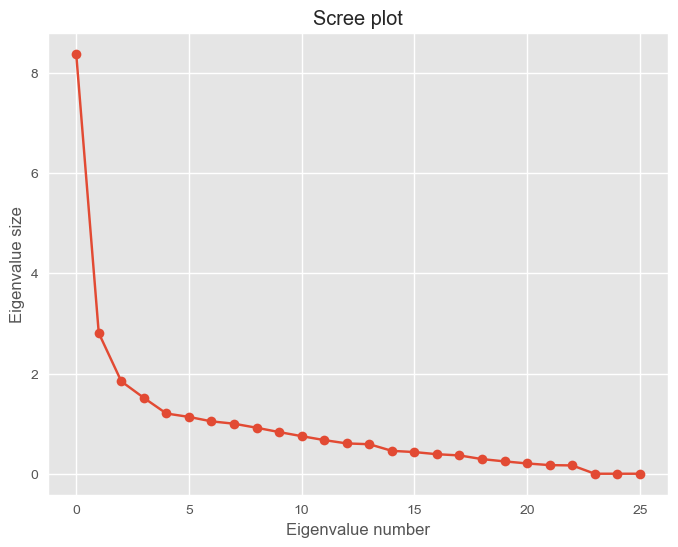

In [15]:
fig = plt.figure(figsize=(8,6))

pca = PCA(n_components=None)
pca.fit(scaled_ds)

plt.style.use('ggplot')
plt.plot(pca.explained_variance_, marker='o')
plt.xlabel('Eigenvalue number')
plt.ylabel('Eigenvalue size')
plt.title('Scree plot')

In [16]:
len(pca.explained_variance_ratio_)

26

In [17]:
#sum(pca.explained_variance_ratio_[:12])
var_exp = []
X = 0
for i in range(len(pca.explained_variance_ratio_)):
    X += pca.explained_variance_ratio_[i]
    var_exp.append(X)

var_exp[11]

0.8494119535653417

Text(0.5, 1.0, 'Scree Plot')

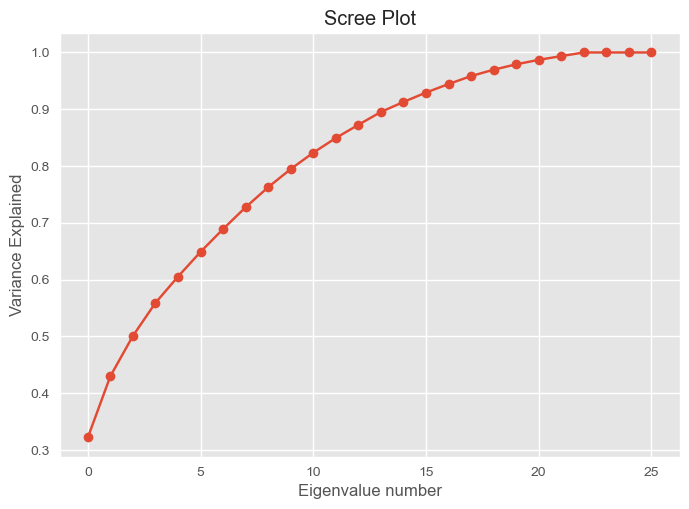

In [18]:
plt.style.use('ggplot')
plt.plot(var_exp,marker='o')
plt.xlabel('Eigenvalue number')
plt.ylabel('Variance Explained')
plt.title('Scree Plot')

In [19]:
pca = PCA(n_components=13)
pca.fit(scaled_ds)
PCA_ds = pca.transform(scaled_ds)

In [21]:
PCA_ds.shape

(2212, 13)

In [22]:
pca.explained_variance_*100/sum(pca.explained_variance_)

array([36.92396419, 12.36867854,  8.12154123,  6.66822244,  5.2949191 ,
        4.99361274,  4.60442334,  4.39640917,  4.04234243,  3.66242915,
        3.30230286,  2.95712099,  2.66403383])

In [25]:
mycolumns = ['Column_1', 'Column_2', 'Column_3', 'Column_4', 'Column_5', 'Column_6', 'Column_7', 'Column_8', 'Column_9', 'Column_10', 'Column_11', 'Column_12', 'Column_13']

In [26]:
df_pca = pd.DataFrame(PCA_ds, columns = mycolumns)
df_pca.head()

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,Column_11,Column_12,Column_13
0,5.238518,-0.138190,1.305140,2.555481,-1.905334,1.667532,0.047885,-0.450903,-0.549859,1.672595,0.162136,0.108167,0.167770
1,-2.910484,-0.276641,-2.006266,0.401136,-0.481219,-0.758566,1.387153,-0.191527,1.138505,0.932402,-0.584373,0.238598,-0.093330
2,2.436117,-0.325151,-0.862204,-0.333291,-0.451392,1.075311,0.082656,-0.526591,0.764948,-2.127730,0.007753,0.076686,-0.624158
3,-2.884476,-1.191339,0.009888,-1.418809,0.691401,0.396966,0.589953,-0.431398,1.457696,-0.660386,-0.594803,-0.181946,-0.197576
4,-0.306196,0.872200,0.495180,-1.250618,1.003662,-1.600900,-1.147963,0.388237,-0.339474,0.427072,0.800258,-0.379860,0.654508


In [27]:
df_pca.to_csv('pca.csv', index= False)

## 2D-Plot

<AxesSubplot:xlabel='Col1', ylabel='Col2'>

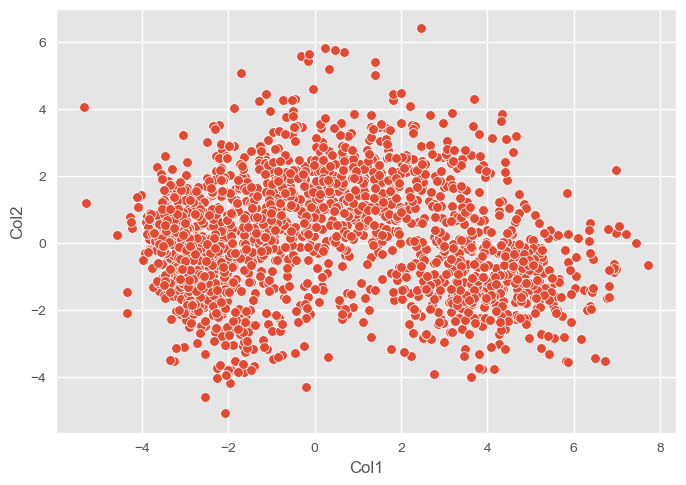

In [28]:
pca = PCA(n_components = 2)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(['Col1','Col2']))
sns.scatterplot(x=PCA_ds.Col1, y=PCA_ds.Col2)

## 3D-Plot

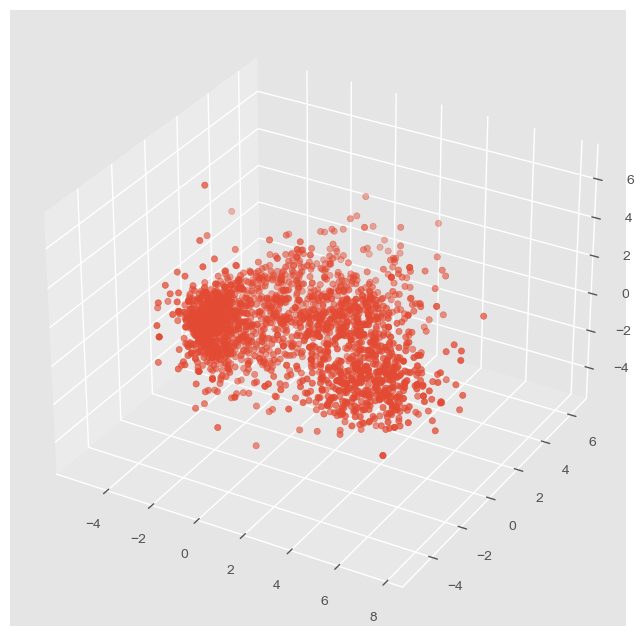

In [29]:
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(['Col1','Col2','Col3']))

fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection = '3d')

ax.scatter3D(xs= PCA_ds.Col1, ys= PCA_ds.Col2, zs= PCA_ds.Col3, cmap='Greens')

# K-means

## Choosing ideal no of clusters

### 3.1.1 Elbow method

Elbow Method to determine the number of clusters to be formed:


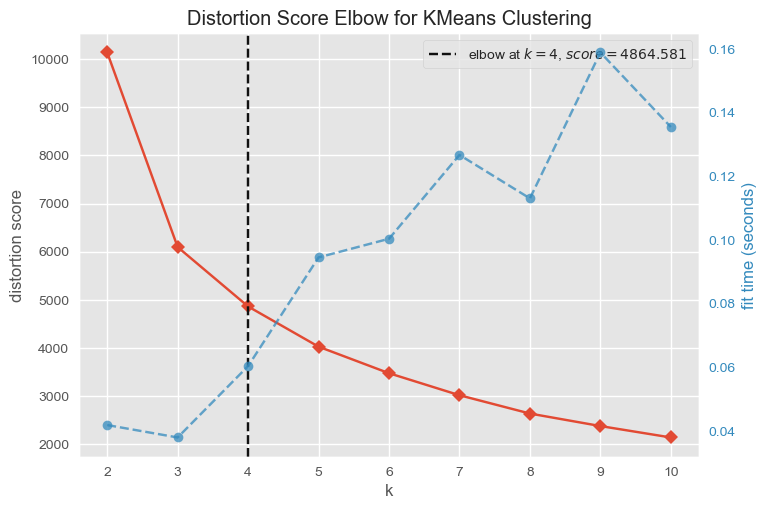

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [30]:
pca = PCA(n_components = 2)
pca.fit(scaled_ds)
PCA_ds = pca.transform(scaled_ds)
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

## Silhouette score and inertia

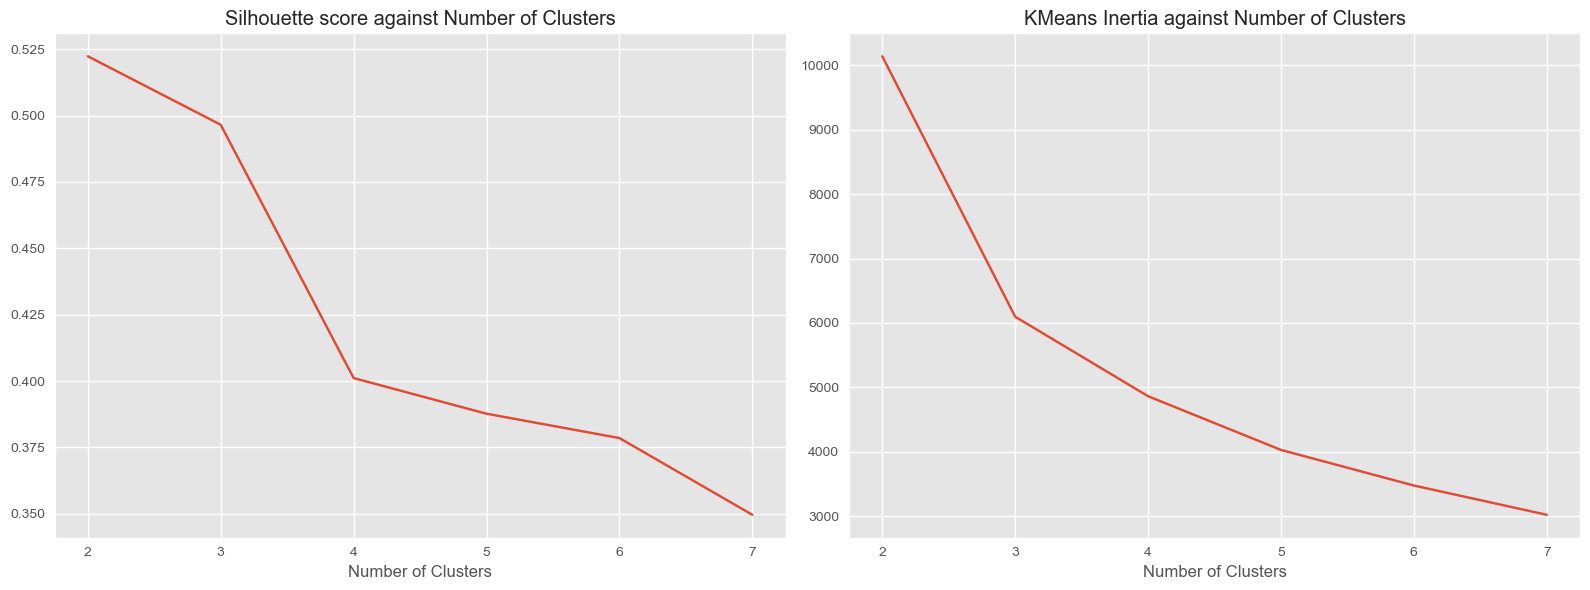

In [31]:
silhouette_score_list = []
inertia_list = []

for n in range(2,8):
    kmeans = KMeans(n_clusters = n, random_state = 0)
    kmeans.fit(PCA_ds)
    silhouette_score_list.append(silhouette_score(PCA_ds, kmeans.labels_))
    inertia_list.append(kmeans.inertia_)
    
#plot
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.plot(range(2,8), silhouette_score_list, '-');
ax1.set_title('Silhouette score against Number of Clusters')
ax1.set_xlabel('Number of Clusters')
ax2.plot(range(2,8), inertia_list, '-')
ax2.set_title('KMeans Inertia against Number of Clusters')
ax2.set_xlabel('Number of Clusters')
plt.tight_layout();

### WCSS (within-cluster sum of Square)

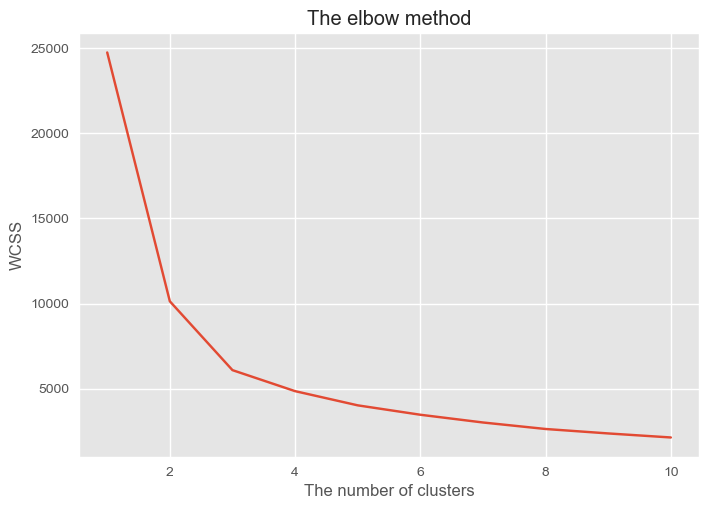

In [32]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(PCA_ds)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,11), wcss)
plt.title('The elbow method')
plt.xlabel('The number of clusters')
plt.ylabel('WCSS')
plt.show()

# Visualizing Data

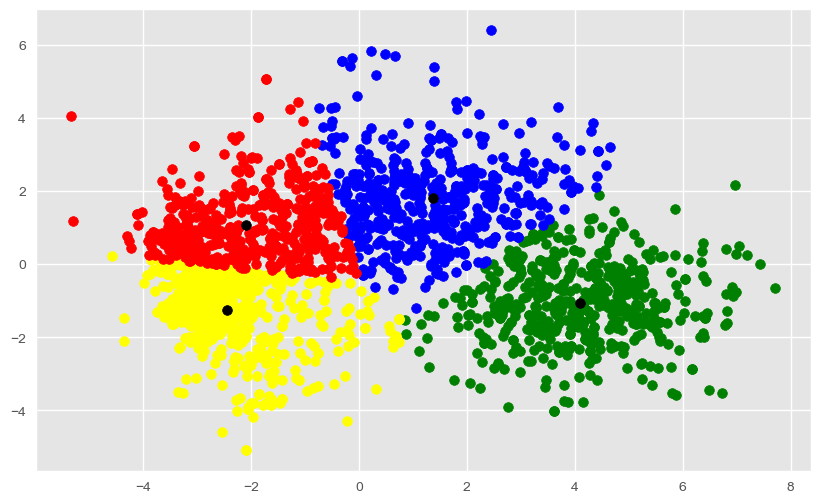

In [36]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)

pca = PCA(n_components=2)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2"]))

Y = kmeans.fit_predict(PCA_ds)

PCA_ds= PCA_ds.to_numpy()

plt.figure(figsize=(10,6))
plt.scatter(PCA_ds[Y==0,0], PCA_ds[Y==0,1], c='green')
plt.scatter(PCA_ds[Y==1,0], PCA_ds[Y==1,1], c='yellow')
plt.scatter(PCA_ds[Y==2,0], PCA_ds[Y==2,1], c='blue')
plt.scatter(PCA_ds[Y==3,0], PCA_ds[Y==3,1], c='red')
#plt.scatter(PCA_ds[Y==4,0], PCA_ds[Y==4,1], c='violet')


plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='black')

plt.show()

#  Hierarchical Clustering

#  EDA

In [48]:
df2['cluster'] = Y
df2.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_Age,Totalspent,TotalPurchase,No_of_Children,Has_child,Age_Group,Customer for,Living with,Family size,Cluster,cluster
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,57,1617,25,0,No Child,Middle Age,971,Alone,1,0,0
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,60,27,6,2,Has Child,Middle Age,125,Alone,3,1,1
2,Graduation,Together,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,49,776,21,0,No Child,Middle Age,472,Relationship,2,0,0
3,Graduation,Together,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,30,53,8,1,Has Child,Adult,65,Relationship,3,1,1
4,PhD,Married,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,33,422,19,1,Has Child,Adult,321,Relationship,3,3,3


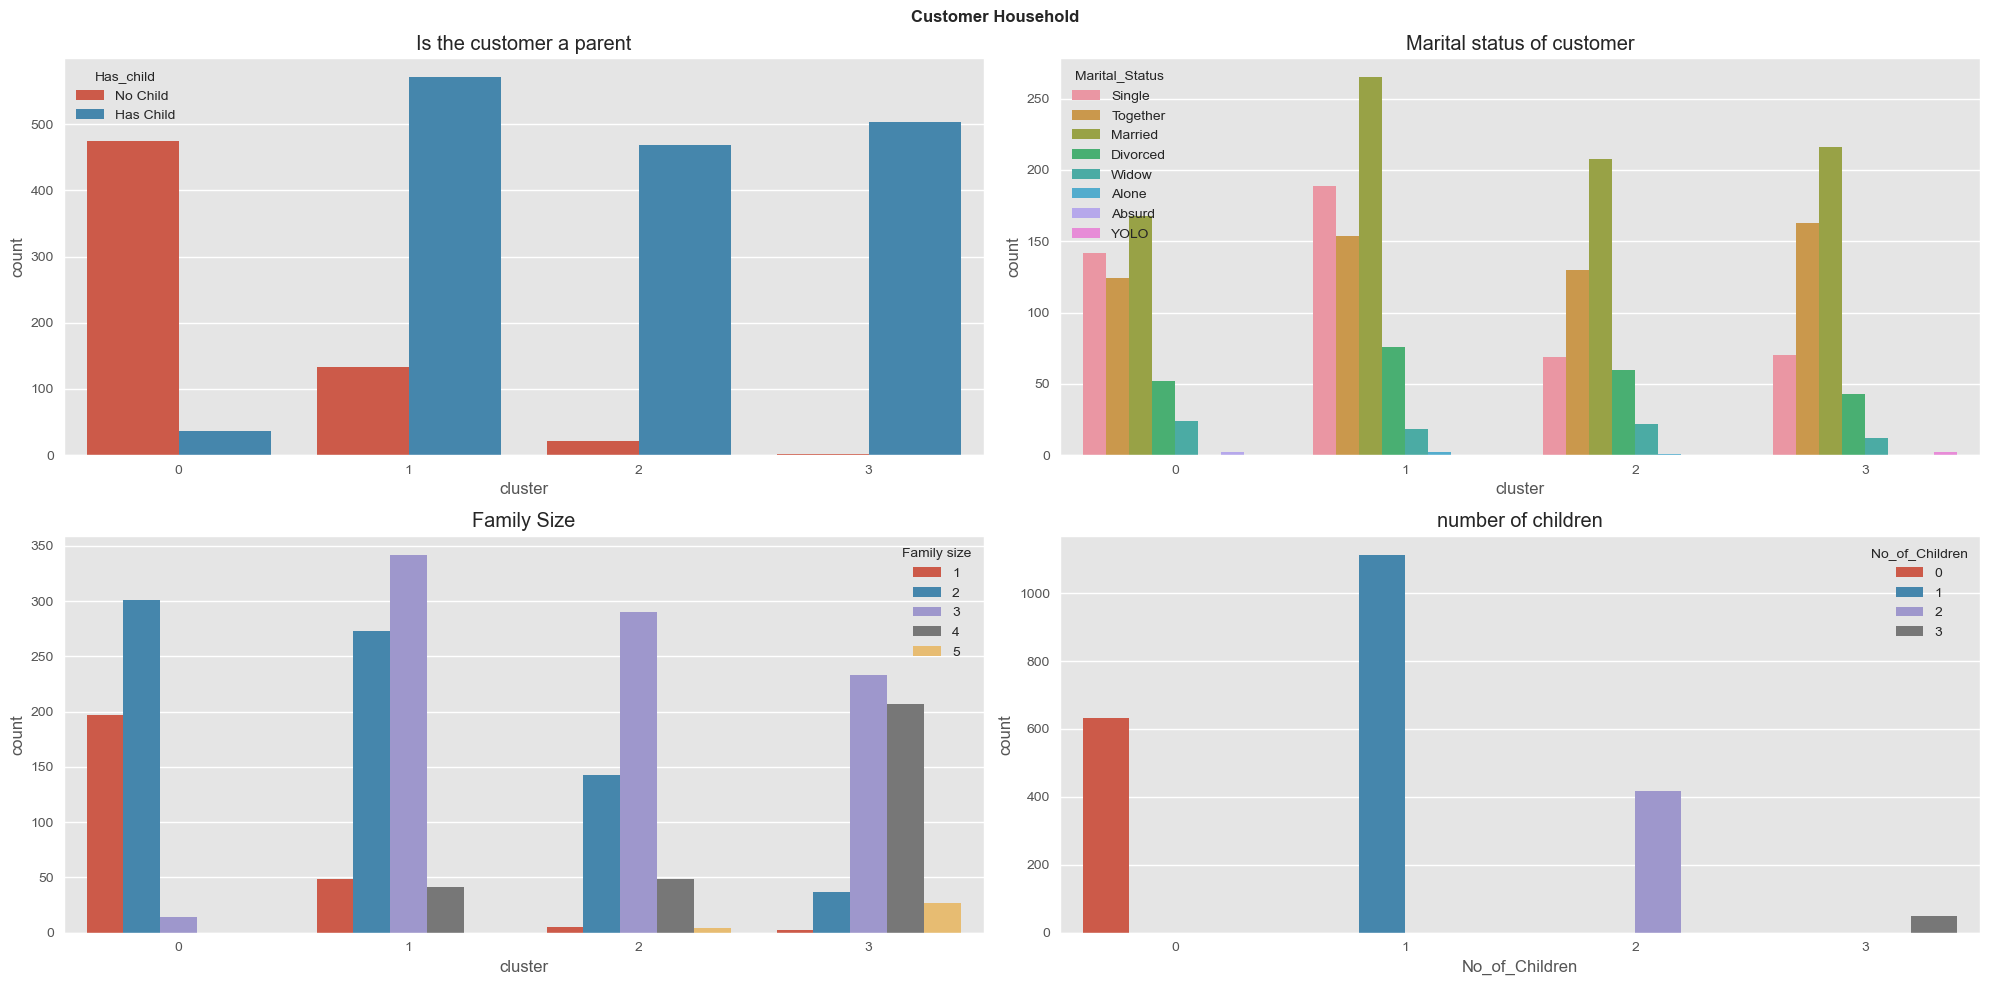

In [54]:
#subplots
fig, (ax) = plt.subplots(2,2, figsize=(20,10))
ax = ax.ravel()
fig.suptitle('Customer Household', fontweight='bold')

sns.countplot(hue='Has_child', x='cluster', data=df2, ax=ax[0])
ax[0].set_title('Is the customer a parent')

#marital status of customer
sns.countplot(x='cluster', hue='Marital_Status', data=df2, ax=ax[1])
ax[1].set_title('Marital status of customer')

#number of members in household
sns.countplot(x='cluster', hue='Family size', data=df2, ax=ax[2])
ax[2].set_title('Family Size')

#number of children in household
sns.countplot(x='No_of_Children', hue='No_of_Children', data=df2, ax=ax[3])
ax[3].set_title('number of children')
plt.tight_layout();

In [55]:
df2.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_Age,Totalspent,TotalPurchase,No_of_Children,Has_child,Age_Group,Customer for,Living with,Family size,Cluster,cluster
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,57,1617,25,0,No Child,Middle Age,971,Alone,1,0,0
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,60,27,6,2,Has Child,Middle Age,125,Alone,3,1,1
2,Graduation,Together,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,49,776,21,0,No Child,Middle Age,472,Relationship,2,0,0
3,Graduation,Together,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,30,53,8,1,Has Child,Adult,65,Relationship,3,1,1
4,PhD,Married,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,33,422,19,1,Has Child,Adult,321,Relationship,3,3,3


In [56]:
cat_features = ['Education','Marital_Status','Has_Child','Age_Group']

Text(0, 0.5, 'mean number of purchases ')

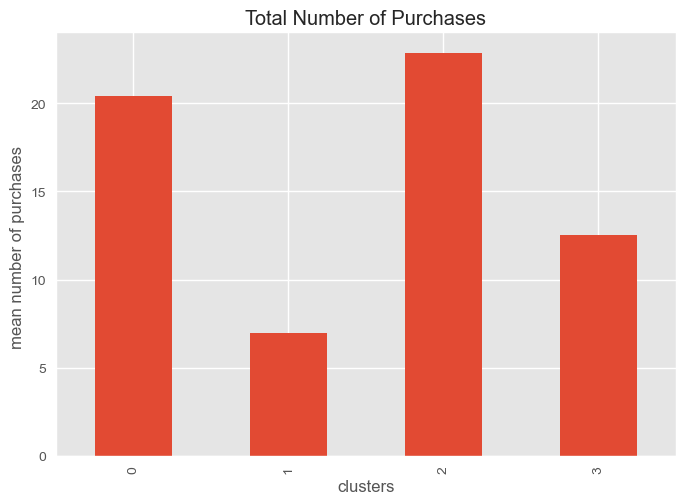

In [59]:
df2.groupby('cluster')['TotalPurchase'].mean().plot.bar()
plt.title('Total Number of Purchases')
plt.xlabel('clusters')
plt.ylabel('mean number of purchases ')

#This plot provides a visual representation of the average number of purchases made by each cluster

Text(0, 0.5, 'mean number of Deal Purchases ')

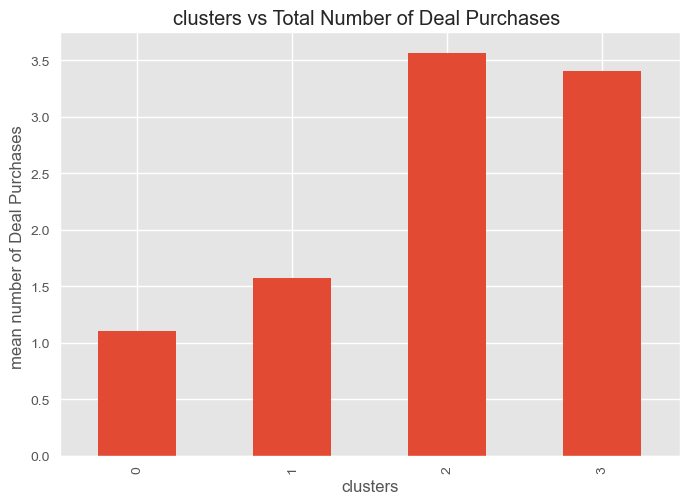

In [60]:
df2.groupby('cluster')['NumDealsPurchases'].mean().plot.bar()
plt.title('clusters vs Total Number of Deal Purchases ')
plt.xlabel('clusters')
plt.ylabel('mean number of Deal Purchases ')

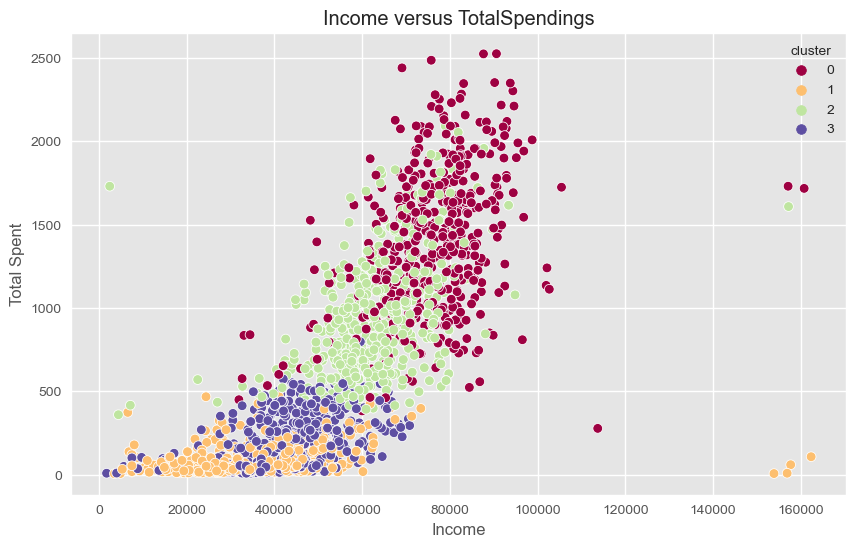

In [63]:
plt.figure(figsize=(10,6))
sns.scatterplot(y='Totalspent', x='Income', hue='cluster', data=df2, palette='Spectral')
#plt.xlim([0, 200000])
plt.title('Income versus TotalSpendings')
plt.ylabel('Total Spent');